# Data Exploration - Bikesharing in Washington

## Business Context

The Bike-sharing system trend is growing in big cities around the world. It has become a viable alternative to public transport or private vehicles for urban commuters. More and more people are enticed to use it because it helps reduce road congestion, noise and pollution. 

In Europe alone, surveys estimate that the Bike-sharing market will grow to 5.6BN euros from 3.6BN euros currently. Meanwhile in the US, there were around 35 MN trips in 2017 which almost double compared to the previous year. One of the known Bike sharing programs in the US is Capital Bikeshare which is based in Washington D.C. 

Capital Bikeshare is currently faced with a challenge to meet growing demand of Bike sharing users in the city. Some of the reasons why demand is growing in the city are: Washington ranks 6th among US Cities in terms of traffic congestion. Moreover, the city is also the 6th most visited city in the US. Lastly, average yearly temperature is 18.2 degrees Celsius.  

In order to meet the growing demand, our team recommends that Capital Bikeshare sets strategies both on the demand side and the supply side. For the demand side, we believe they should implement a dynamic pricing strategy to balance/regulate the demand throughout the day and at the same time reduce forgone potential revenue. In the supply side, they can optimally allocate bike assets/resources to ensure availability of bikes whenever and wherever they are highly demanded. They can also redirect customers to nearby stations with a bigger amounts of bike available. 

However, in order to implement these strategies a central question needs to be answered day frequently: How will Capital Bikeshare be able to estimate the demand for their bikes? 

Our team det up a machine learning model to help Capital Bikeshare to answer this question. The team was divded into three groups that not only collaborated but also exchanged ideas and insight to make this project successful. One part of the team was responsible for understanding the business behing bikesharing and finding additional resources for the machine learning model. The second part of the team was responsible for exploring and cleaning the provided data and the third part of the team took care of the actual machine learning model in order to forecast the hourly bikesharing demand.

In the following we walk you through all the steps we took in order to build the model. Please note that we have a separate jupyter notebook for data exploration and the model. This made it easier for us to work on the codes at the same time.

## 1. Library loading

In [53]:
import dask.dataframe as dd
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly

## 2. Data loading

In order to read data files we created a function that takes advantage of the panda command read_csv. Here we only have to state the input path and the file is loaded as a panda dataframe. In order to be able to collaborate and execute the notebook on several computers the data was uploaded to Gist. With this we only need to insert the the url under which the dataset is stored.

In [2]:
def read_data(input_path):
    raw_data = dd.read_csv(input_path)
    return raw_data

#### Hourly data set

In [37]:
data = read_data('https://gist.githubusercontent.com/aromerovilla/7170e4ff45dd943af6a920d2f510cd0f/raw/b5732e3122ca9d0dec95717b62434e2b68e642b6/hour.csv')

In [6]:
data.info()
data.dtypes

<class 'dask.dataframe.core.DataFrame'>
Columns: 17 entries, instant to cnt
dtypes: object(1), float64(4), int64(12)

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

Within the variable data the hourly data set is stored. It contains 17,379 rows and 17 columns. The info of the dataset reveals already that there no null values within the data set. For the predictive model the target value is 'cnt', which is the total number of rented bikes and is the sum of the number of 'casual' and 'registered' users, which are also stored in the data set. However, several variables are not stored in the correct data type:
- instant: This is the unique identifier within the dataset. It rather functions as an index and cannot be interpreted as a numeric variable.
- season: The four different seasons (winter, spring, summer, winter) are encoded with numbers and represent catgories and not nummerical values.
- yr: actually represents a boolean values indicating if the year of the entry is 2011 (0) or 2012 (1).
- mnth: ranging from 1 to 12 representing the different months within a year and are thus a category since they cannot be interpreted on a nummerical scale.
- hr: ranging from 0 to 23 and are similar to the month variable rather a category than a number.
- holiday: boolean value indicating if the day of the record is an offical holiday (1) or not (0).
- weekday: from 1 to 7 representing the day of the week (Mo to Su) and is thus a categorical variable and not a numeric one.
- workingday: boolean value indicating if the day of the record is a workingday (usually Mo to Fr) (1) or not (weekend or holiday) (0).
- weathersit: representing the wheater condition as a nummeric variable from 1 to 4 but is actually a categoric variable:
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

#### Daily data set

In [36]:
daily = read_data('https://gist.githubusercontent.com/alombatti/60c99f57b916b5c121abbd713273ab86/raw/3618d0d08251995be6550e53980f0c5ffdbbf4c8/daydata.csv')

In [8]:
daily.info()
daily.dtypes

<class 'dask.dataframe.core.DataFrame'>
Columns: 16 entries, instant to cnt
dtypes: object(1), float64(4), int64(11)

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In addition to the hourly data set the data set was also provided on daily basis. We took advantage of this data set especially when comparing biking patterns among different days of the week. The daily data set contains 731 rows since 2012 is a leapyear. The data set has the same variables and thus variable types as the hourly data set. As well there are no null values in the daily data set.

## 3. Plots

As I would do in real life, I sampled the dataset in order to visualize it. It has to run on a single machine, so I sampled ny dask dataframe and converted it into a pandas dataframe.

In [38]:
data = data.sample(frac = 0.3, replace=True)
daily = daily.sample(frac = 0.3, replace=True)

In [39]:
data = data.compute()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5214 entries, 333 to 1575
Data columns (total 17 columns):
instant       5214 non-null int64
dteday        5214 non-null object
season        5214 non-null int64
yr            5214 non-null int64
mnth          5214 non-null int64
hr            5214 non-null int64
holiday       5214 non-null int64
weekday       5214 non-null int64
workingday    5214 non-null int64
weathersit    5214 non-null int64
temp          5214 non-null float64
atemp         5214 non-null float64
hum           5214 non-null float64
windspeed     5214 non-null float64
casual        5214 non-null int64
registered    5214 non-null int64
cnt           5214 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 733.2+ KB


In [40]:
daily = daily.compute()
daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 151 to 220
Data columns (total 16 columns):
instant       219 non-null int64
dteday        219 non-null object
season        219 non-null int64
yr            219 non-null int64
mnth          219 non-null int64
holiday       219 non-null int64
weekday       219 non-null int64
workingday    219 non-null int64
weathersit    219 non-null int64
temp          219 non-null float64
atemp         219 non-null float64
hum           219 non-null float64
windspeed     219 non-null float64
casual        219 non-null int64
registered    219 non-null int64
cnt           219 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 29.1+ KB


### 3.1 Plot configuration

Before plotting we configured the plot parameters and figure aestehetics such as font sizes and plot backgrounds taking advantage of the seasborn library (sns = seaborn).

In [41]:
sns.set_style('white')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

### 3.2 Bike rentals among the months

In [42]:
season_col = ["#749ee8", '#ffc9b9','#e69479','#b2d7ff']
month_col = ["#749ee8","#749ee8","#749ee8", '#ffc9b9','#ffc9b9','#ffc9b9','#e69479','#e69479','#e69479','#b2d7ff','#b2d7ff','#b2d7ff']

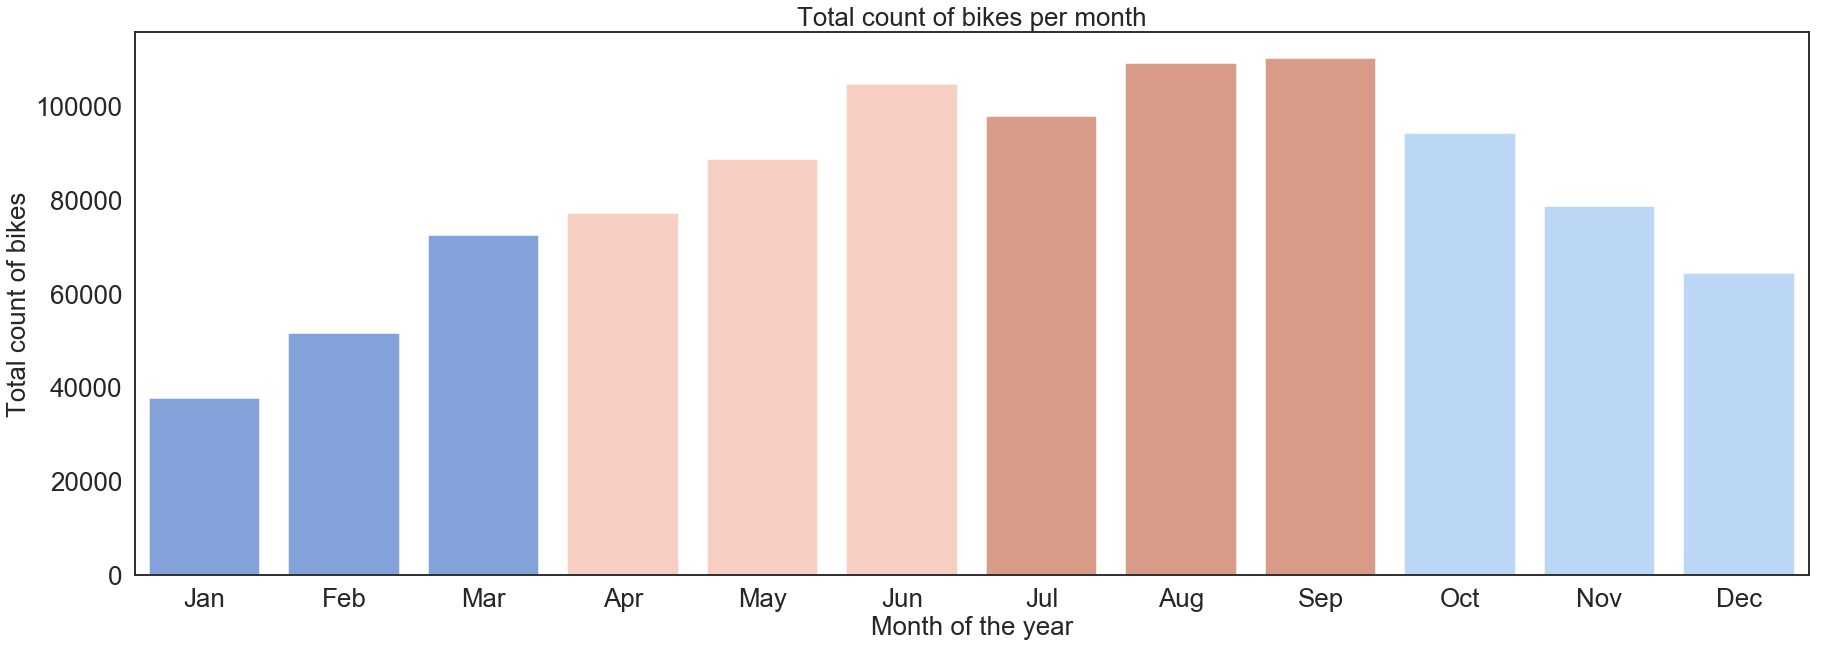

In [43]:
fig, ax = plt.subplots()
monthly_plot = sns.barplot(data = data[['mnth',
                                        'cnt']],
                           x = 'mnth',
                           y = 'cnt',
                           ci = None,
                           palette=month_col,
                           estimator = sum)
ax.set(xlabel = 'Month of the year', ylabel = 'Total count of bikes', title = 'Total count of bikes per month')
ax.set_xticklabels(['Jan','Feb','Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

When we plot the histograms for the different months, we see again clearly the cyclical pattern. While during (hot) summer months many bikes are rented, the overall number decreases during the (cold) winter months. We created a specific color pallete to colour the chart, pointing out the temperature diffence throughout the year but also reflecting to which season which month belongs. (Please note that some months overlap since the seasons end on the 21st. Thus each month is coloured based on the majority of days that belong to that seasons. E.g. March is Winter since 20 days belong to winter).

### 3.3 Bike rentals among seasons

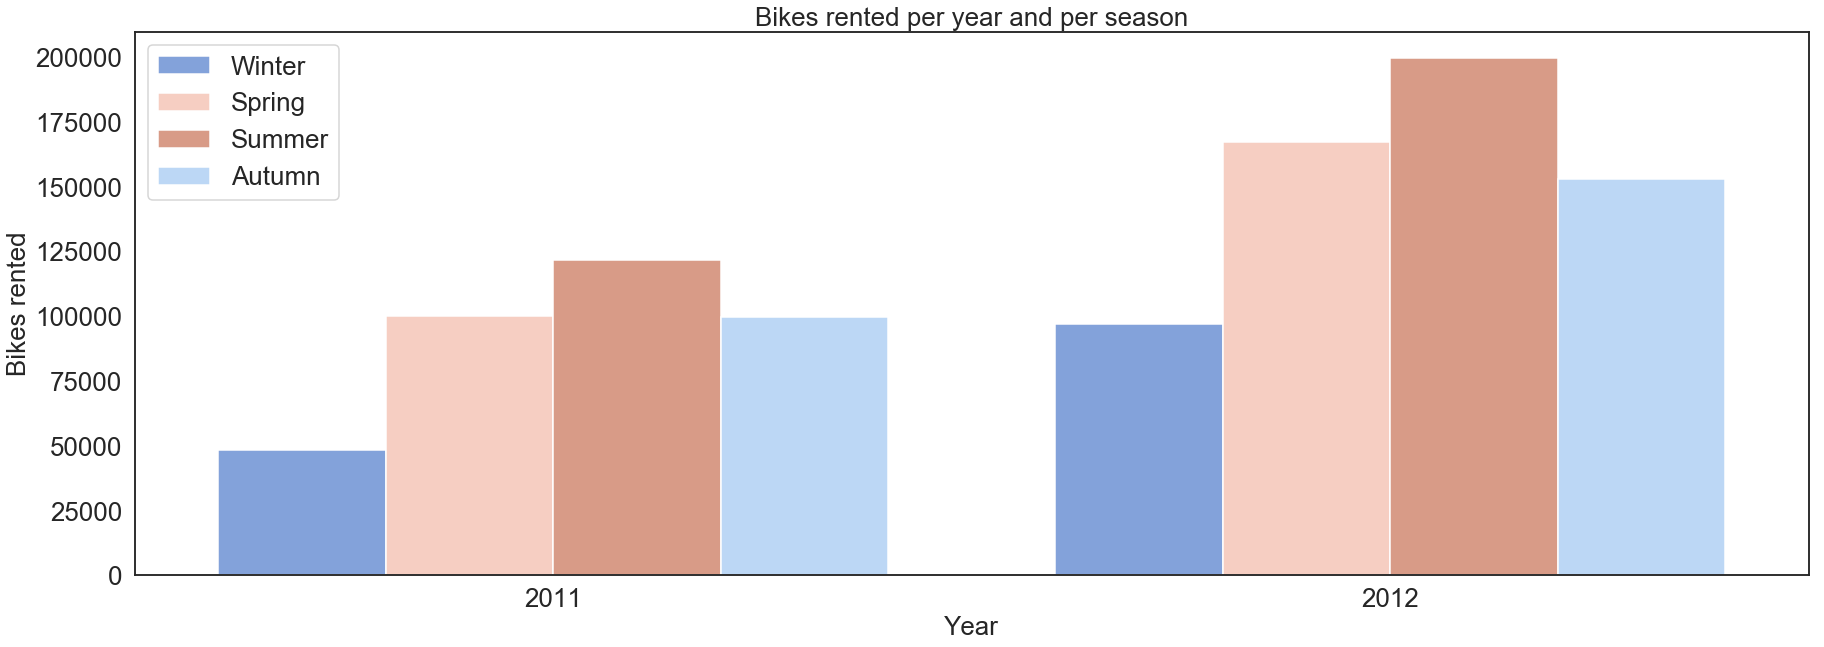

In [44]:
# Number of bikes rented per season
fig, ax = plt.subplots()
plot = sns.barplot('yr',
                   'cnt',
                   hue = 'season',
                   data = data,
                   ci = None,
                   palette=season_col,
                   estimator = sum)
ax.set(xlabel = 'Year', ylabel = 'Bikes rented',title = 'Bikes rented per year and per season')
ax.set_xticklabels(['2011', '2012'])
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ["Winter", "Spring", "Summer", "Autumn"])
plt.show()

Looking at the seasonal histograms splitted within the two years, we can see again the cyclical pattern. The overall level of bike rentals is much higher in 2012 compared to 2011. We can conclude that capital bike share increased in popularity within Washington over the time since more bikes are rented out in 2012 than in 2011 for all four seasons.

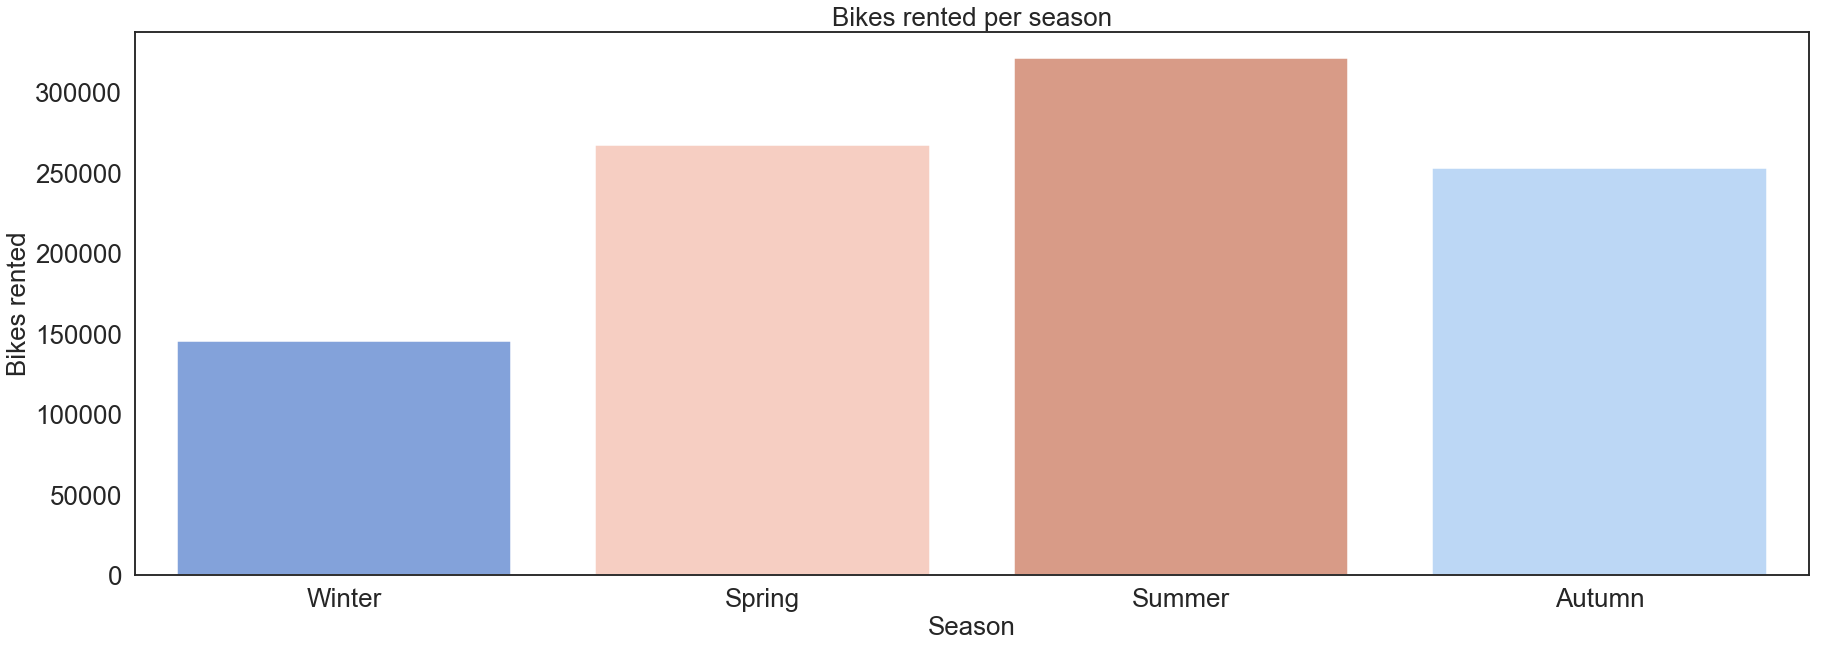

In [46]:
fig, ax = plt.subplots()
season_count = sns.barplot(data=data[['season',
                                      'cnt']],
                           x = 'season',
                           y = 'cnt',
                           ci = None,
                           estimator = sum,
                           palette=season_col)
ax.set(xlabel = 'Season', ylabel = 'Bikes rented',title = 'Bikes rented per season')
ax.set_xticklabels(['Winter', 'Spring', 'Summer', 'Autumn'])
plt.show()

Due to the fact that seasons are an aggregation of months we see the similar trend when separately looking at the two variables. While months is more granular than seasons the differences among the months within a seasons are not that high. Thus it might make sense to only include one of these two variables within the later model.

### 3.4 Bike rentals throughout the day

#### 3.4.1 Total bike rentals per hour - Season breakdown

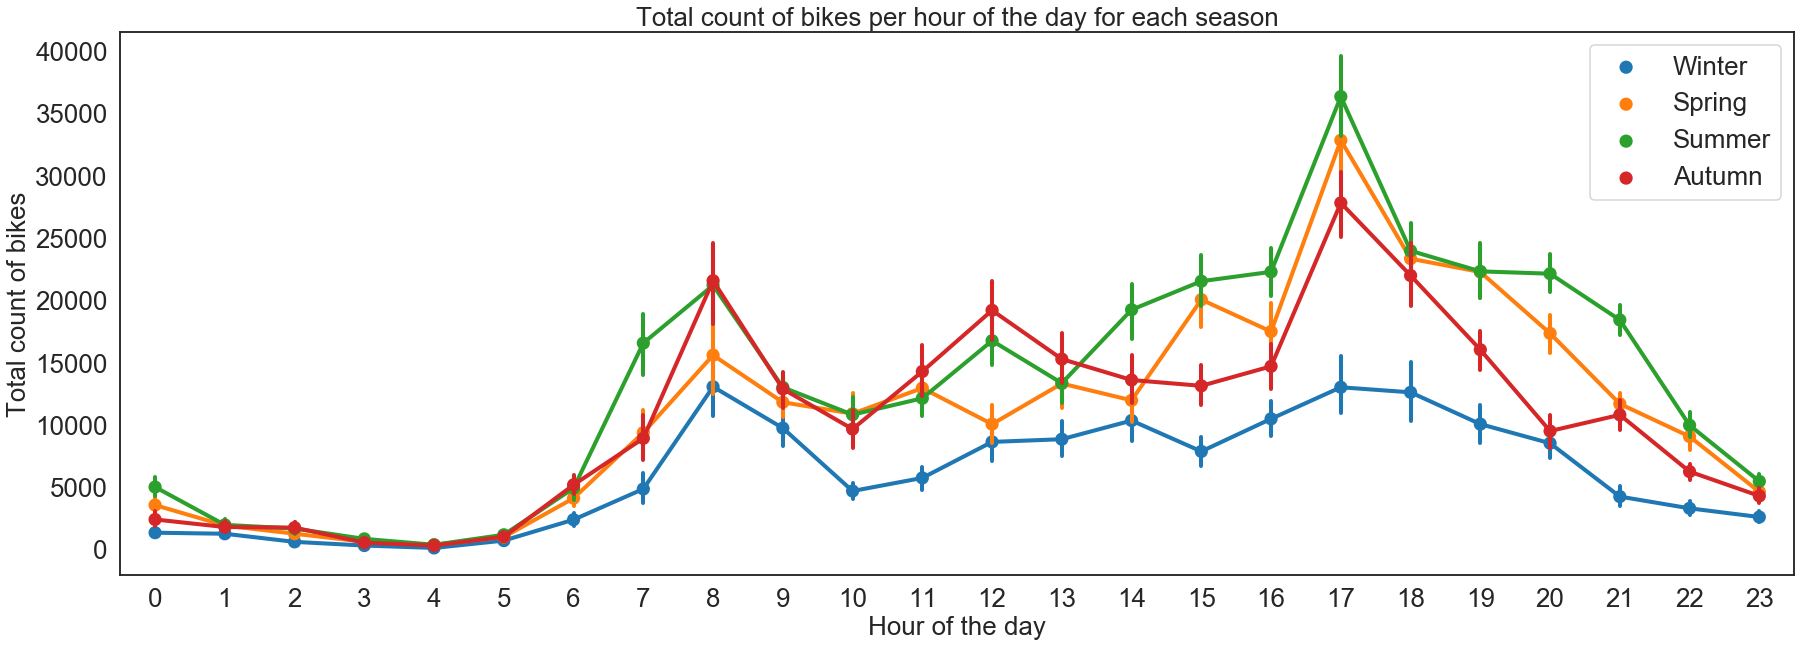

In [48]:
g = sns.pointplot(data = data[['hr', 'cnt','season']],
                  x = 'hr',
                  y = 'cnt',
                  hue = 'season',
                  legend_out = True,
                  estimator = sum)
leg_handles = g.get_legend_handles_labels()[0]
g.legend(leg_handles, ["Winter", "Spring", "Summer", "Autumn"])
g.set(xlabel = 'Hour of the day', ylabel = 'Total count of bikes', title = 'Total count of bikes per hour of the day for each season')
plt.show()

In order to compare if the overall pattern changes during the year, we created a line chart using the seaborn library. It might be possible that the peak hours within a day change from season to season due to the changing sunrise and sundown time. However, for all four seasons we see stable peak hours. However the total amount of bikes rented differs between the seasons. While many bikes are rented throughout the summer, much less bikes are rented during winter. For the time during the night (1am to 5am) we see not really large differences among the seasons. Thus it might make sense here to create an addiotional variable that groups the hours of the day.

#### 3.4.2 Average bike rentals per hour - Workingday vs. Non-Workingday

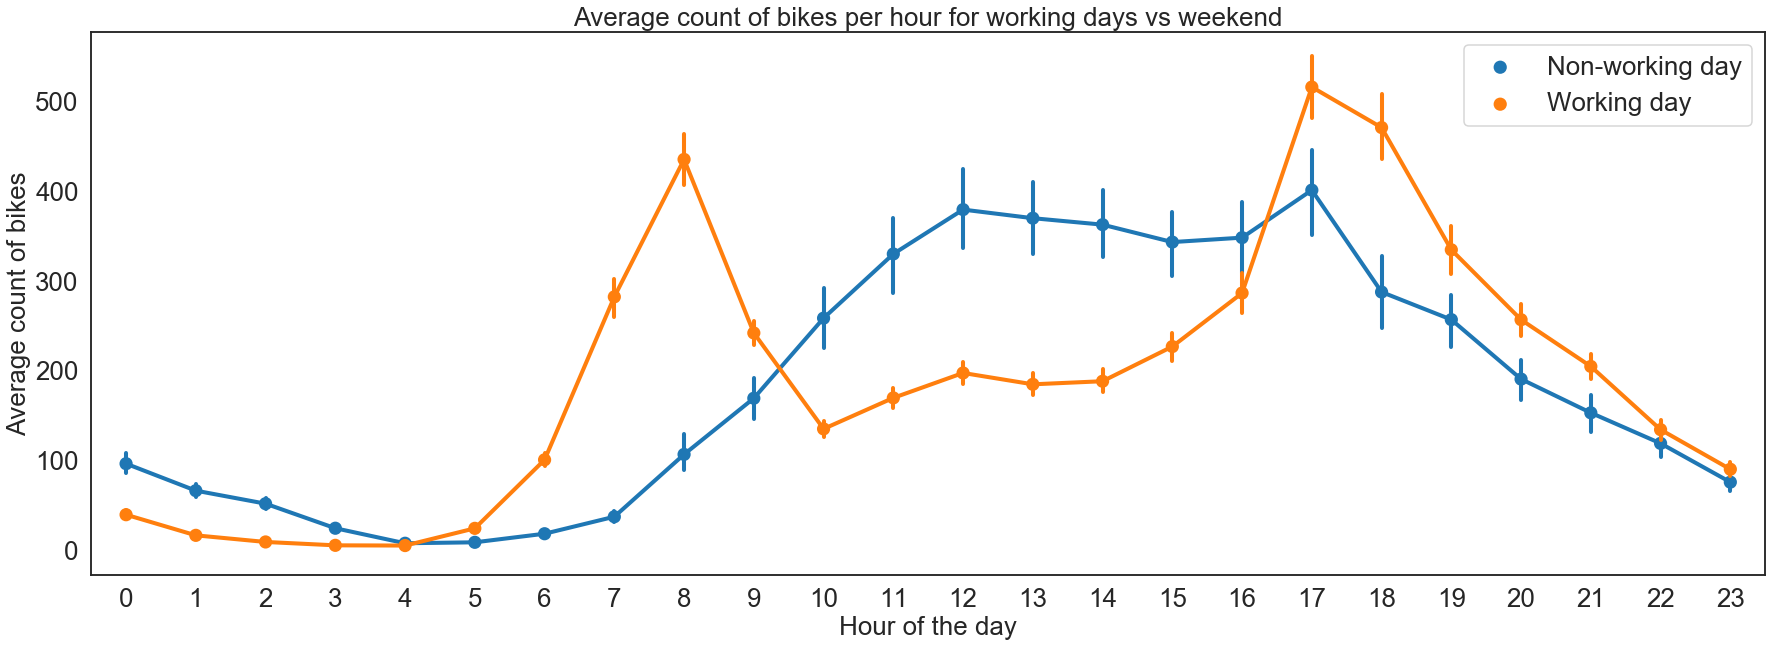

In [54]:
fig, ax = plt.subplots()
wor_week_plot = sns.pointplot(data = data[['hr',
                                           'cnt',
                                           'workingday']],
                              x = 'hr',
                              y = 'cnt',
                              hue = 'workingday',
                              estimator = np.average)
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ["Non-working day", "Working day"])
ax.set(xlabel = 'Hour of the day', ylabel = 'Average count of bikes',title = 'Average count of bikes per hour for working days vs weekend')
plt.show()

The peaks in the previous chart might seem they are highly related to commuting pattern. Main commuting hours are often between 7am and 9am for morning commutes and from 5pm until 7pm or 8pm for evening commutes. However, this is highly related to actual working days. There is much less commute during the weekend, since most office jobs have workingdays from Monday to Friday. Thus we wanted to take a closer look how the daily bike rentals differ between workingdays and non-workingdays such as weekends and holidays. Most of the time non-working days are weekends, thus we mainly refer here to the difference between working days and weekends. By plotting the average demand distinguishing between working and non-working day, we see the clear commuting patterns for working days, while the bike usage is much more stable during the weekend.

This already gives us a clear idea that there are different demand pattern for weekdays compared to weekends, which will be important for the later model. The next step is now to break it down to a more granular level and look at the demand pattern for the different days of the week.

#### 3.4.3 Total bike rentals per hour - Weekday breakdown

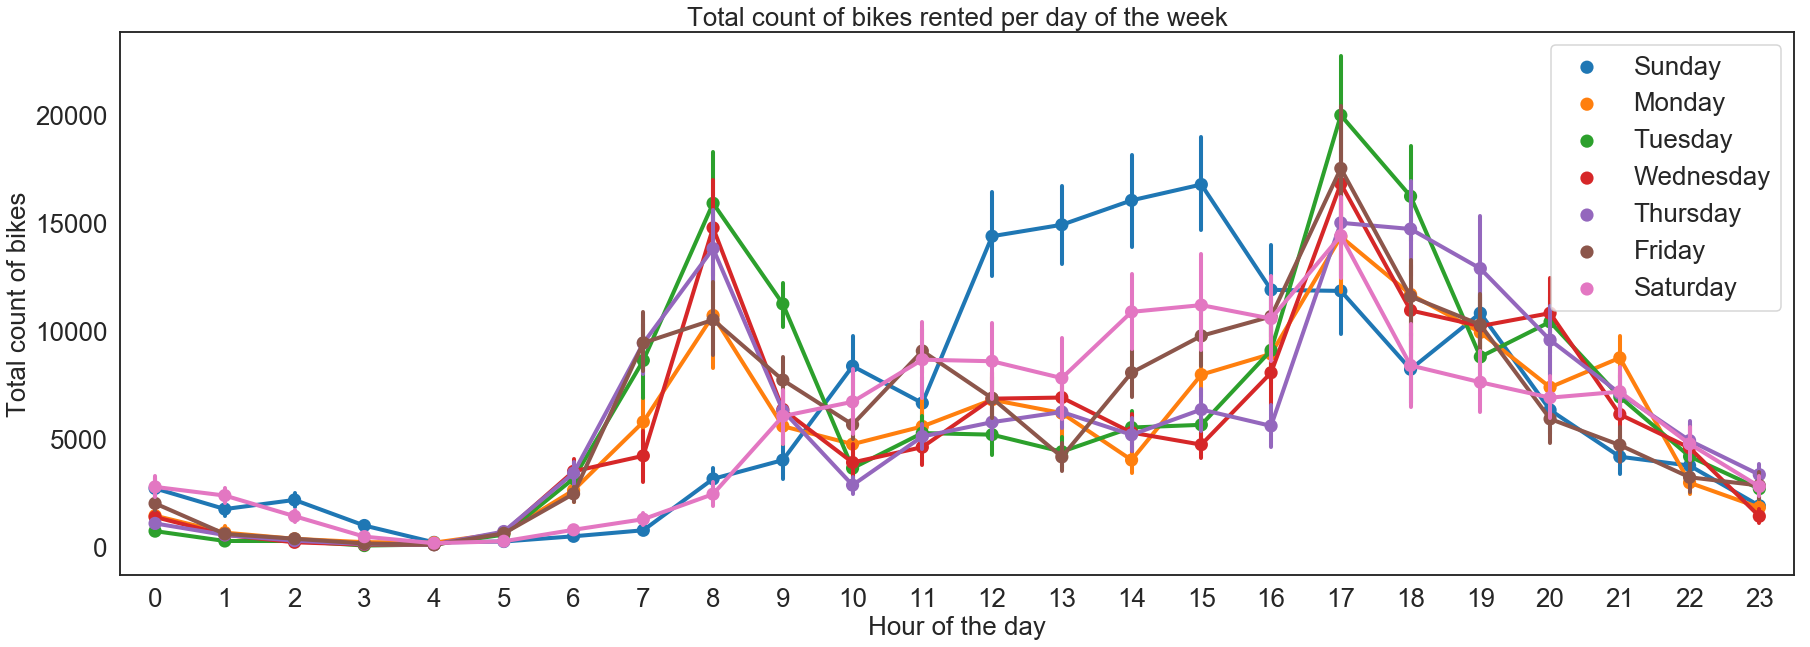

In [56]:
fig, ax = plt.subplots()
week_plot = sns.pointplot(data = data[['hr',
                                       'cnt',
                                       'weekday']],
                          x = 'hr',
                          y = 'cnt',
                          hue = 'weekday',
                          estimator = sum)
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
ax.set(xlabel = 'Hour of the day', ylabel = 'Total count of bikes',title = 'Total count of bikes rented per day of the week')
plt.show()

While we see very similar patterns from Monday to Friday, bike rentals during the weekend show a very different pattern. During the week we see two clear commuting peaks. For the evening commute on Fridays however we see a lower level compared to the other days of the week. This can have multiple reasons such as evening plans within the city after work or that people go home earlier on Fridays. This would explain why we see a higher bike rental level on Friday during lunch time. On the weekends however, there are no peaks but rather a steadily increasing demand from the morning until the early afternoon, that then decreases again during the afternoon. The demand curve for Saturday and Sunday is overall very similar.
Overall we see the the biking demand seems to be a bit lower during the weekend than during the week, however the lunch hours with comparably low demand during the week are the high demand hours during the weekend.
Thus is might not only be important to distinguish between working day and weekend in the model but also between the actual days of the week.

### 3.5 Difference between registered and casual users

#### 3.5.1 Registered users during working and non-working days

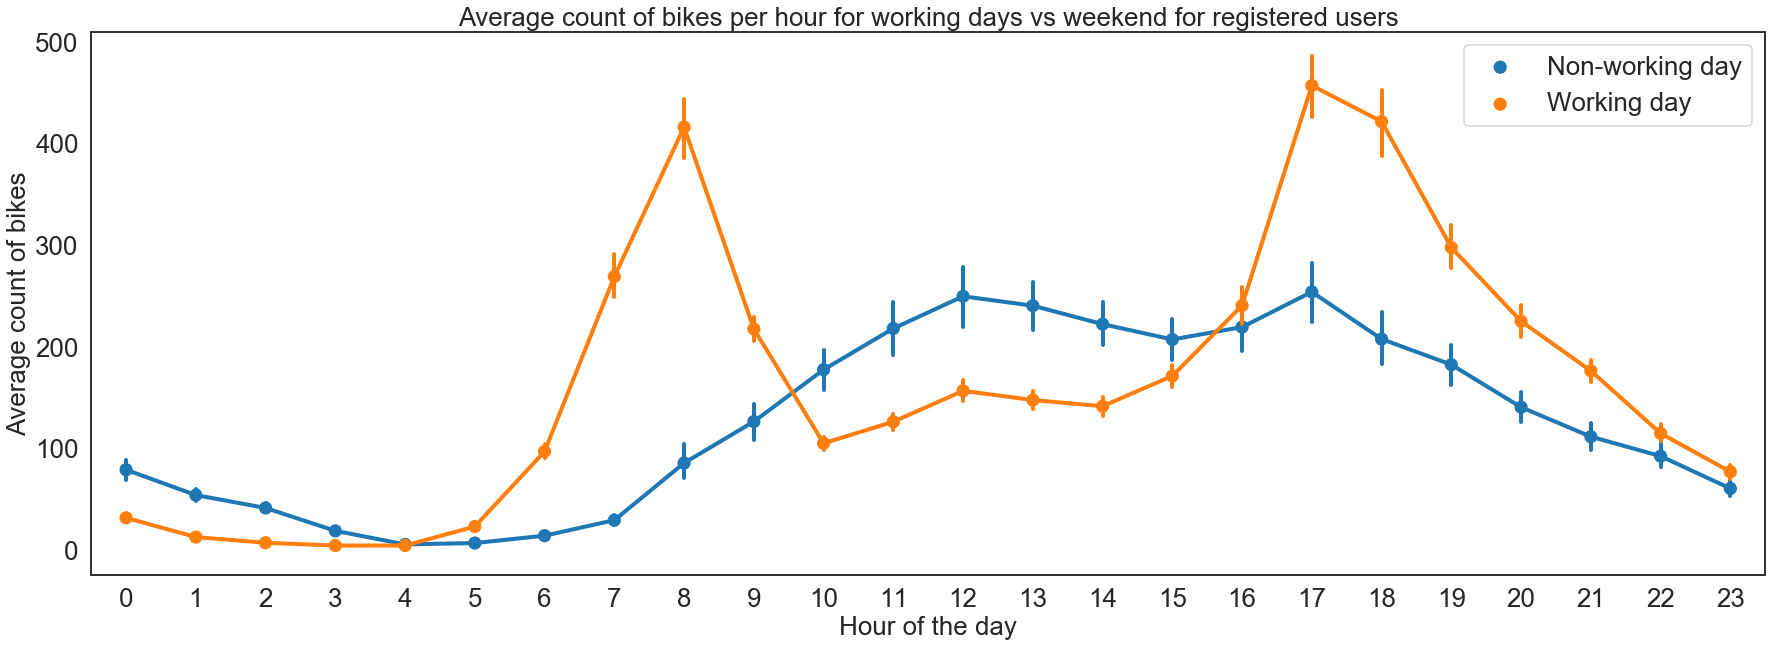

In [59]:
fig, ax = plt.subplots()
wor_week_plot = sns.pointplot(data = data[['hr',
                                           'registered',
                                           'workingday']],
                              x = 'hr',
                              y = 'registered',
                              hue = 'workingday',
                              estimator = np.average)
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ["Non-working day", "Working day"])
ax.set(xlabel = 'Hour of the day', ylabel = 'Average count of bikes',title = 'Average count of bikes per hour for working days vs weekend for registered users')
plt.show()

When plotting the bike rentals for working and non-working days only for registered users, we see again clearly the commuting pattern during the week, but a pretty stable demand pattern during the weekend. More registered user rent bikes during lunch time and also late in the night during the weekends compared to working days. The overall pattern for registered users looks very similare to the overall pattern for the total data set.

#### 3.5.2 Casual users during working and non-working days

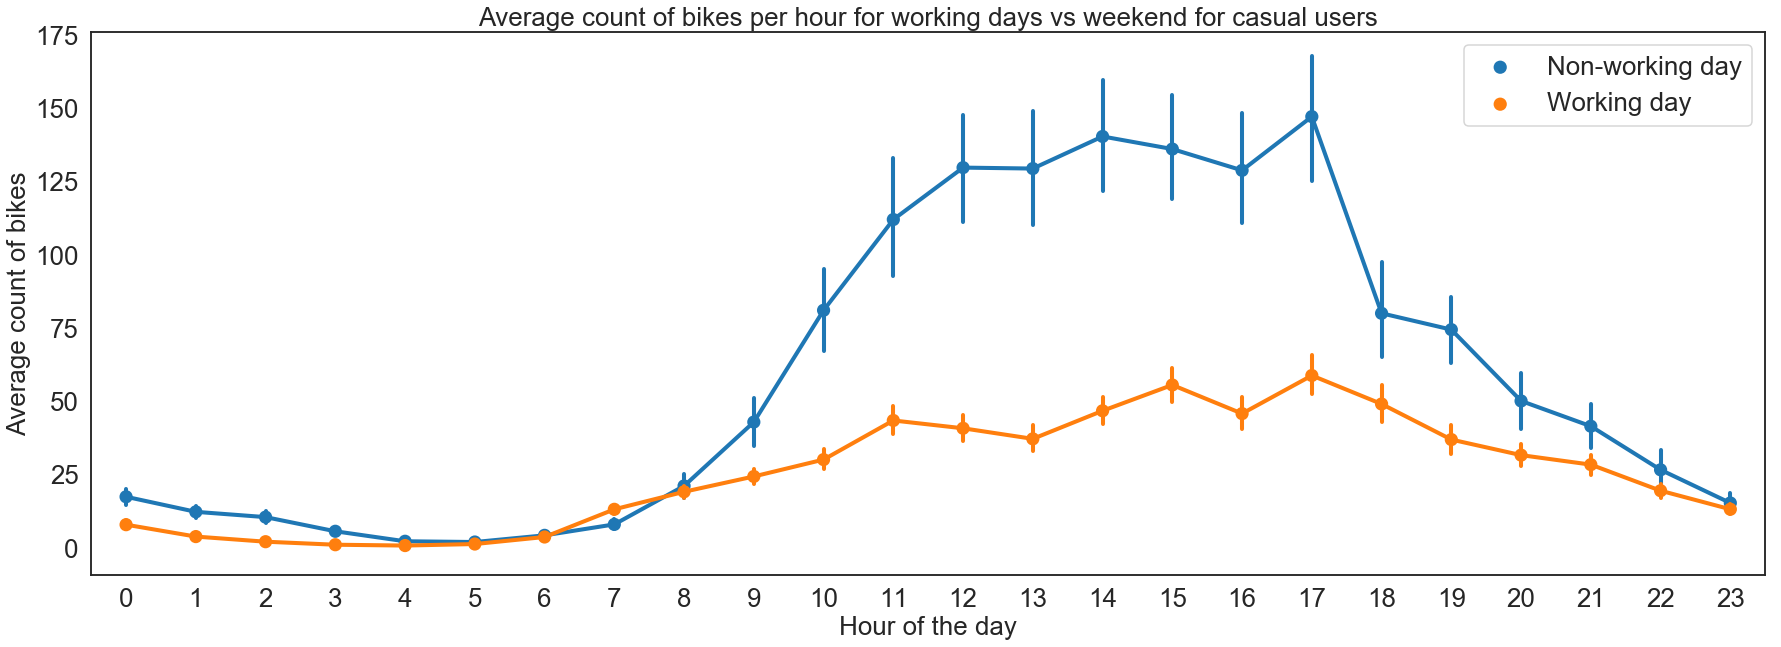

In [60]:
fig, ax = plt.subplots()
wor_week_plot = sns.pointplot(data = data[['hr',
                                           'casual',
                                           'workingday']],
                              x = 'hr',
                              y = 'casual',
                              hue = 'workingday',
                              estimator = np.average)
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ["Non-working day", "Working day"])
ax.set(xlabel = 'Hour of the day', ylabel = 'Average count of bikes',title = 'Average count of bikes per hour for working days vs weekend for casual users')
plt.show()

For casual users we see a very different pattern compared to registered users. There is a small peak during the week at 5pm but overall the usage is comparatively low. During the weekend though the usage is much higher and increases during lunch time.

### 3.6 Outlier detection

#### 3.6.1 Boxplot for hours of the day

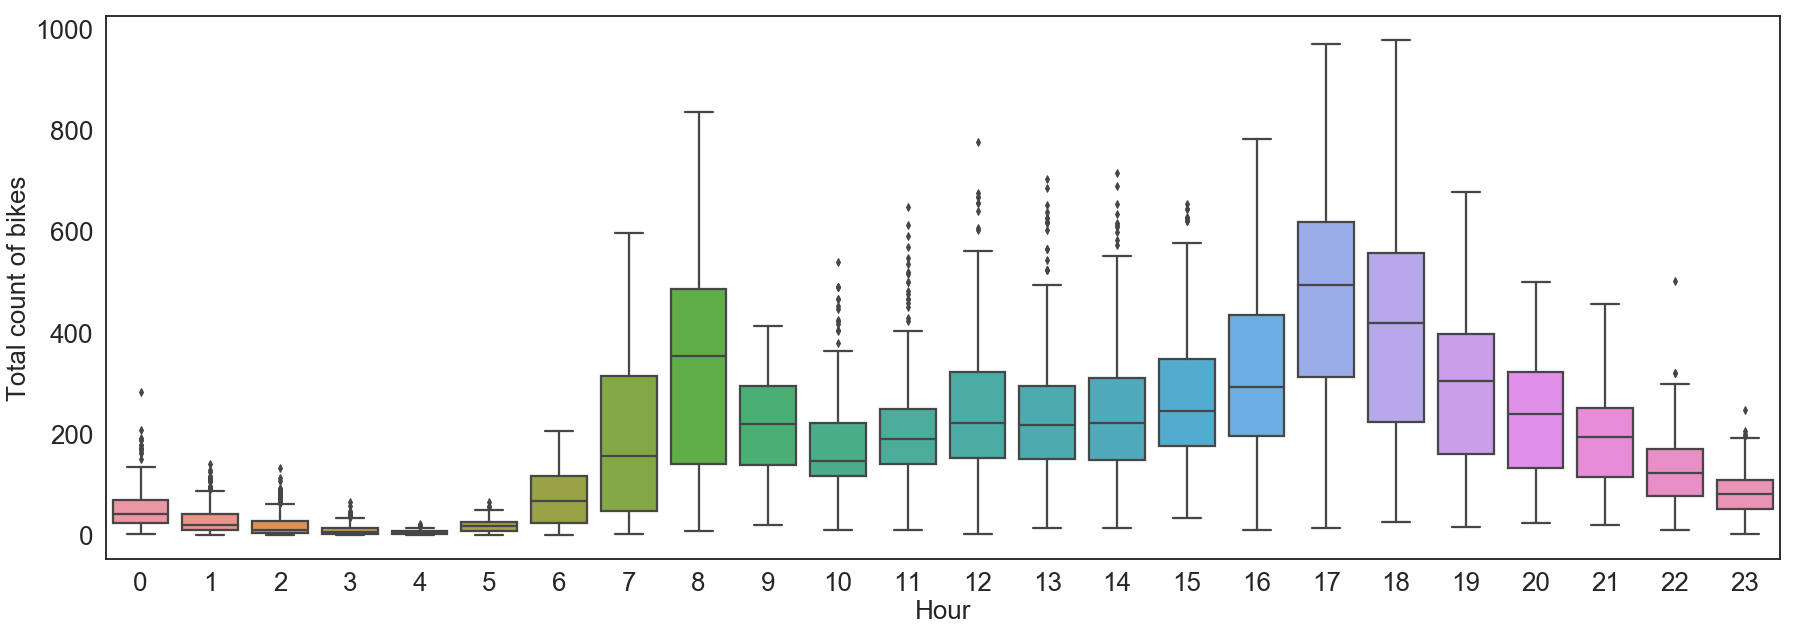

In [62]:
fig, ax = plt.subplots()
outliers = sns.boxplot(data = data[['cnt',
                                    'hr']],
                       x = 'hr',
                       y = 'cnt')
ax.set(xlabel = 'Hour', ylabel = 'Total count of bikes')
plt.show()

In order to detect outliers we plotted box plots for each hour of the day using the total count of bike rentals. For the further detected peak hours there are not ourliers. However, especially during lunch time and during the nigh we see several hours with unusual high bike rentals. These number might be noise but could also be reasonable due to special events that happened in Washingthon.

### 3.7 Relationship of weather variables

#### 3.7.1 Relationship between weather variables

/Users/albertolombatti/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning:

The `size` parameter has been renamed to `height`; pleaes update your code.



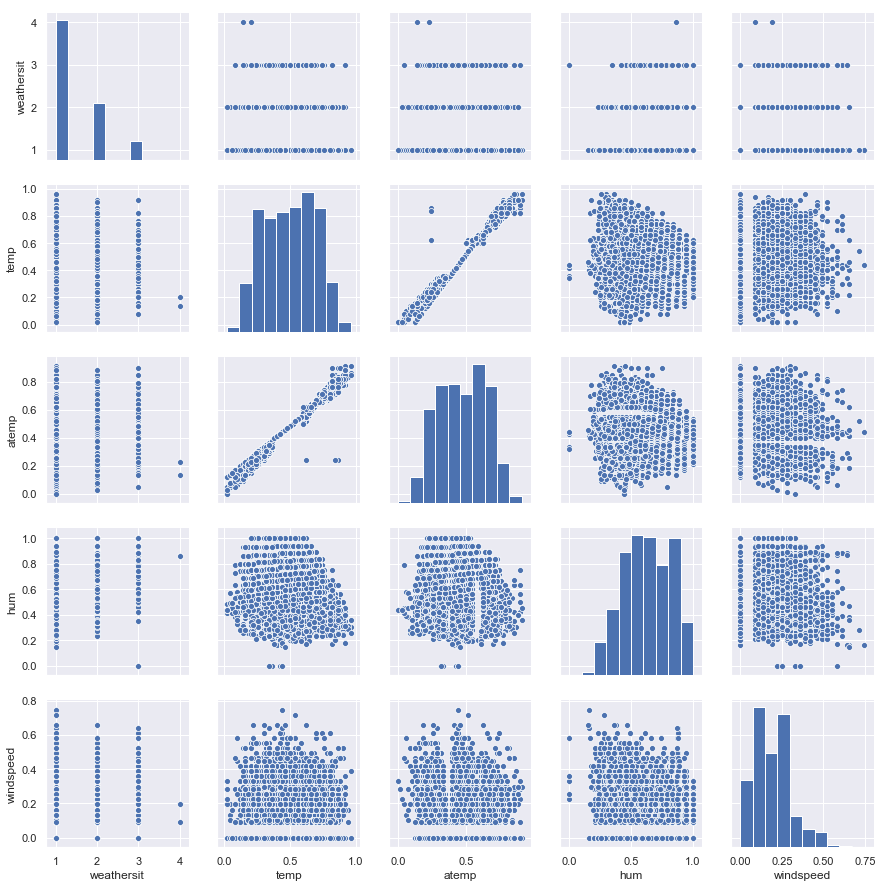

In [64]:
sns.set()
cols = ['weathersit','temp','atemp','hum','windspeed']
sns.pairplot(data[cols], size = 2.5)
plt.show();

In order to detect specific relationships between the weahter variables we used the seaborn pairplots to not only plot the histograms of the variables but also the relationship between all pairs of weather variables. This might help to cluster groups of weather variables together.

Overall, it does not seem like there are very apparent clusters within the data set for weather. Only for temperature and felt temperature there seems to be a group of values that is very different from the linear relationship between the two values. It might make sense to cluster them, however we already know that these variables are highly correlated so it might even make more sense to just drop one of the two variables.

Furthermore, we see that for windspeed we have values that are 0, which are clearly a separate group for all these pairs. Thus it is likely that windspeed values that are 0 are acutally wrongly recorded values.

#### 3.7.2 Effect of temperature on bike rentals

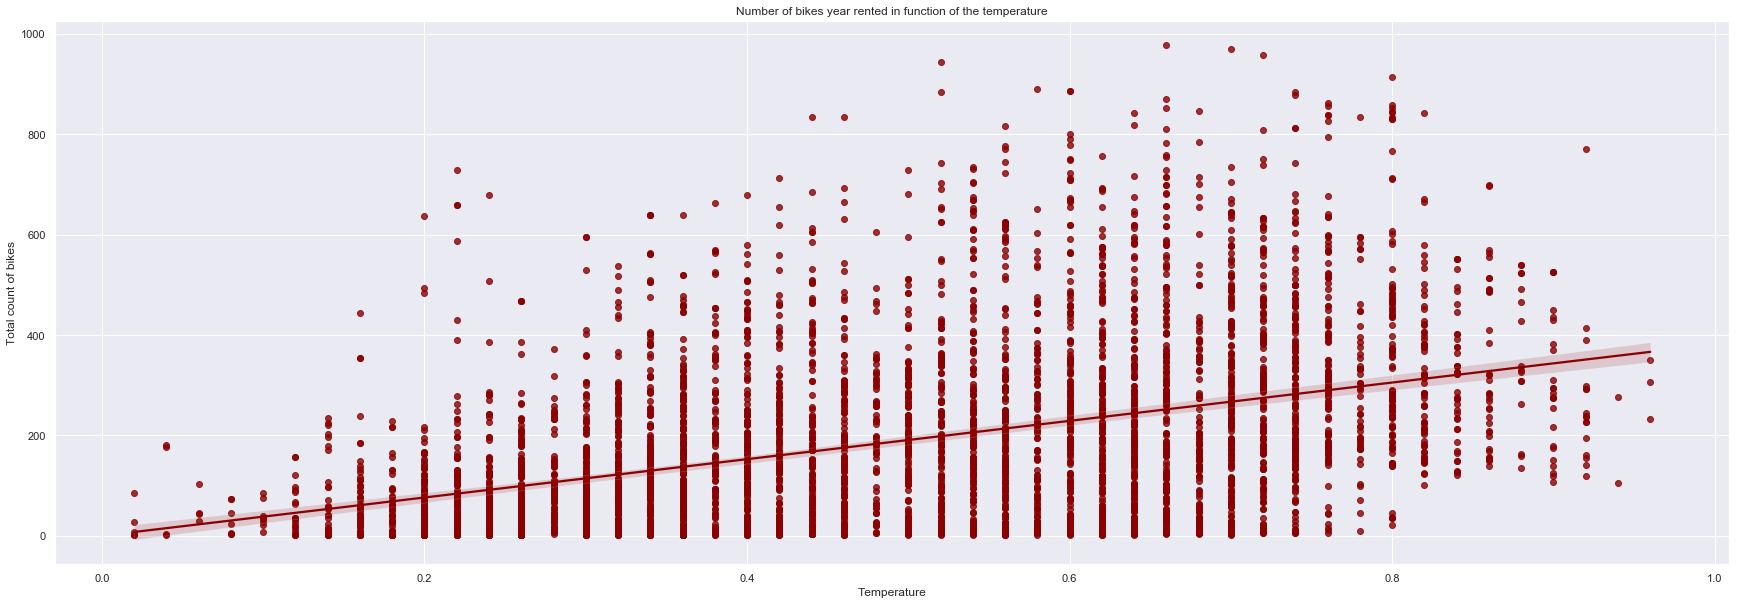

In [65]:
fig, ax = plt.subplots()
sns.regplot(x = data["temp"],
            y = data["cnt"],
            fit_reg = True,
            ci = 100,
            truncate = True,
            color = 'DarkRed')
ax.set(xlabel = 'Temperature', ylabel = 'Total count of bikes',title = 'Number of bikes year rented in function of the temperature')
plt.show()

In order to detect a general trend that might be related to temperature we created a regression plot with searborn. We see that overall there is positive relationship between temperature and the number of bike rentals. However, when it is extremely hot there are no hours with no bike rentals. Usually those hours are during the day and not during the night, thus it is reasonable that there are bike rentals eventhough it is very hot. So even though it might seem incorrect at first sight, it actually makes sense.